In [2]:
import os 
import sys
import re 
import numpy as np
import agilent_loader as ag
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import warnings
import PyMi as pmi

folder = "GL1"

results_folder = folder+"\\Results"

pmi.check_and_prepare_folder(results_folder)

files_in_folder = pmi.get_mi_files_in_folder(folder)

print(f" Found {len(files_in_folder)} files in {folder}")


Folder 'GL1\Results' already exists and is now empty.
 Found 1 files in GL1


2
graphing topography
2 0.5
0.5 scale length 0.5
showing


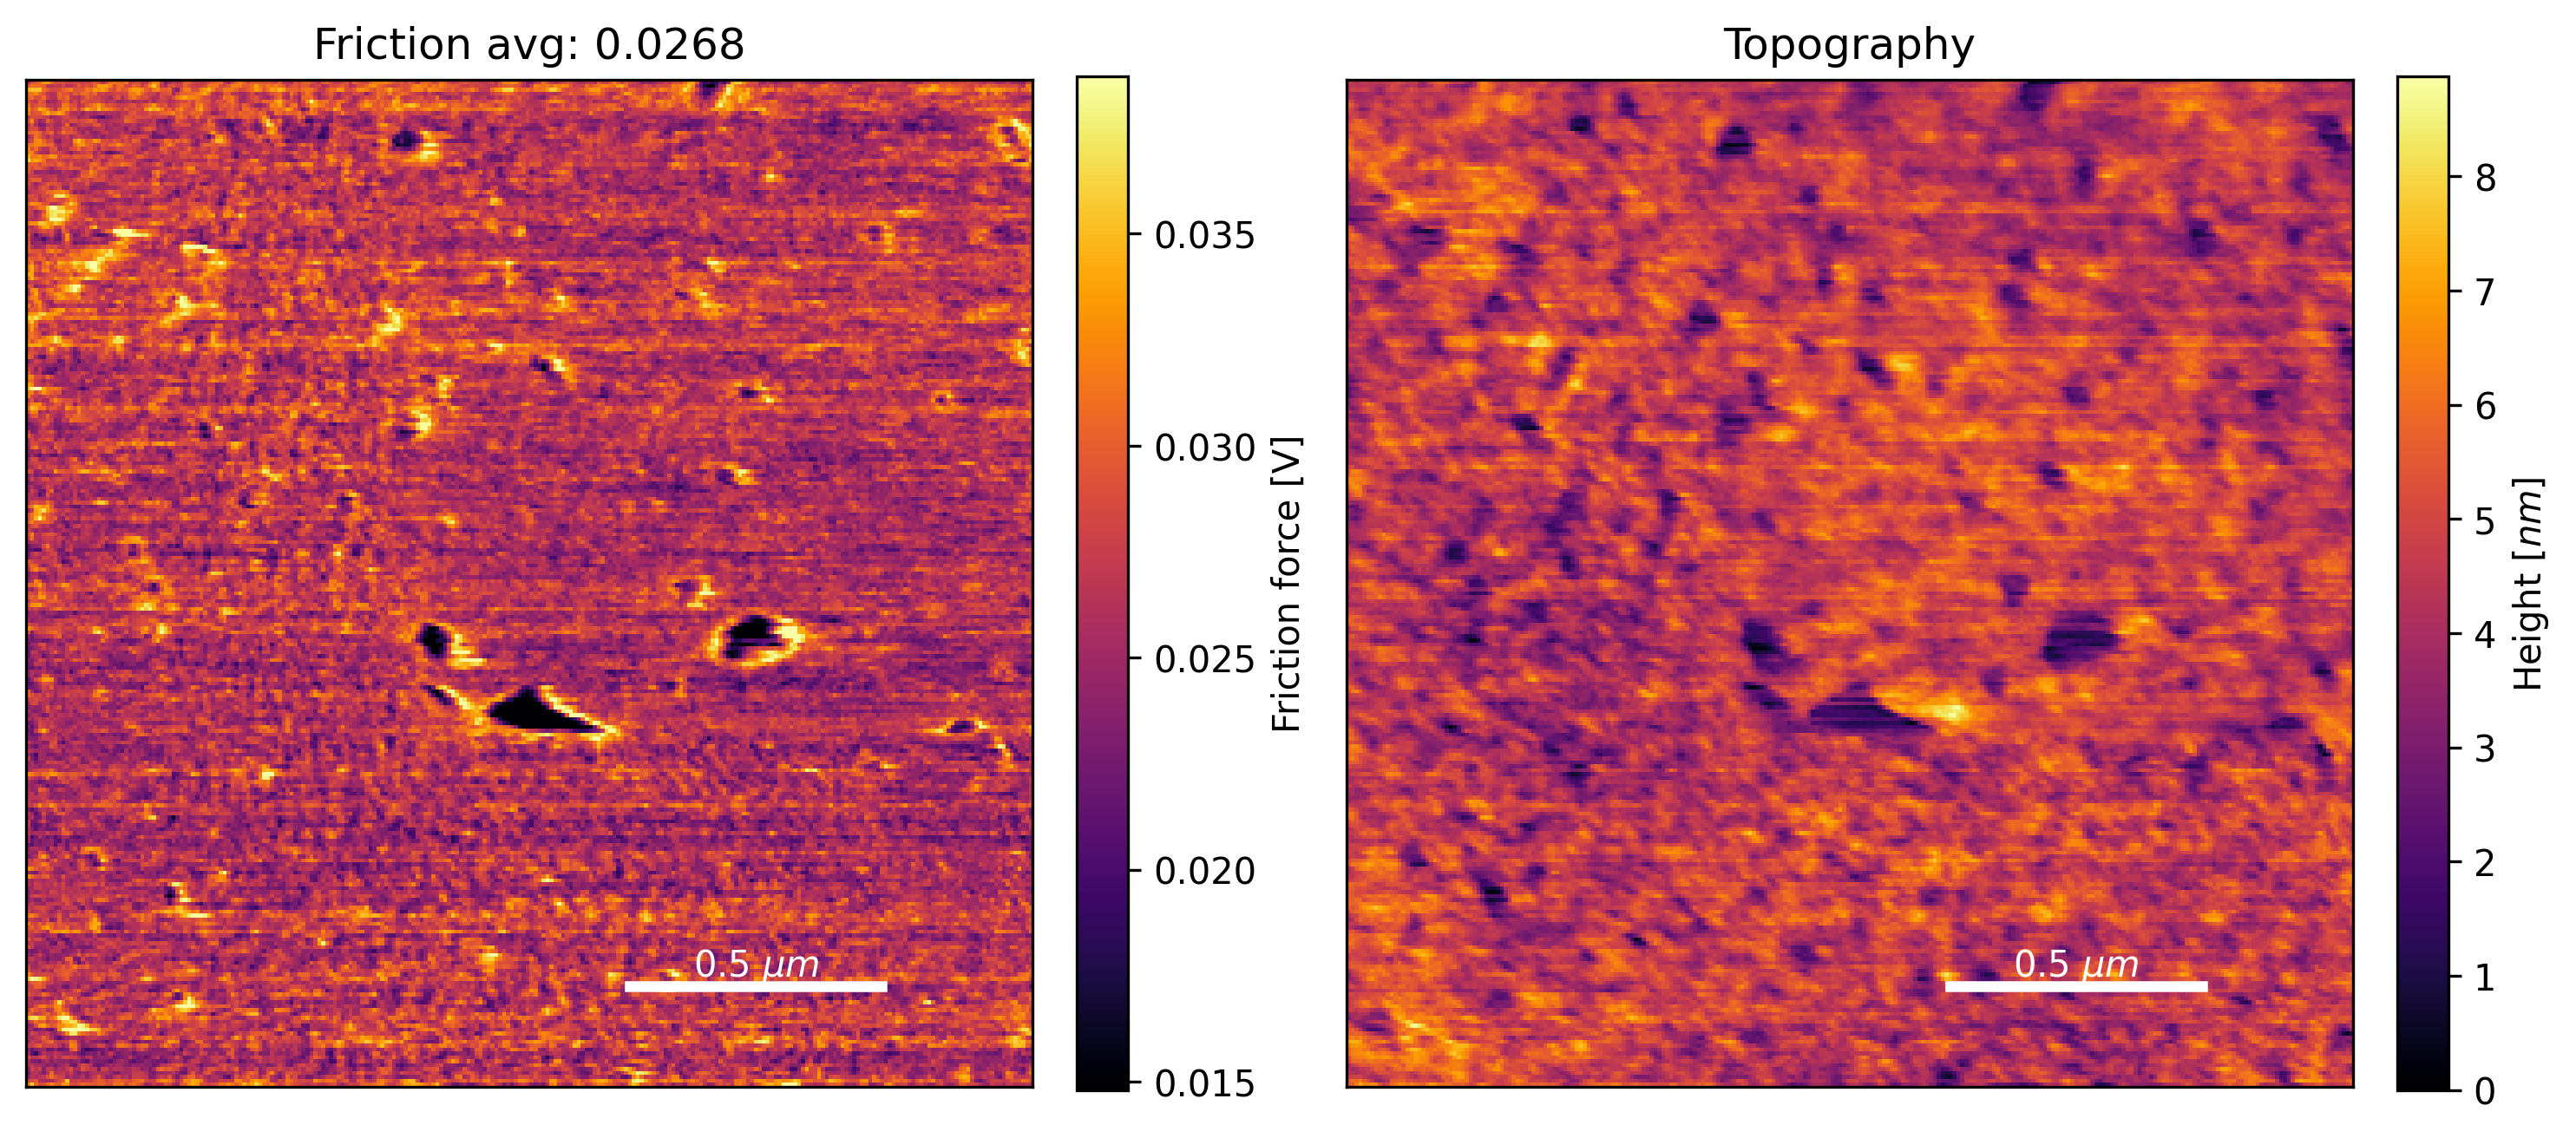

In [5]:
Cof_for_runs=np.zeros(len(files_in_folder))
Cof_for_runs_std=np.zeros(len(files_in_folder))
ii=0

scale_length=0.5

multiple_files=False
if len(files_in_folder)>2:
	multiple_files=True


for file_path in files_in_folder:
	
	file=ag.load_mi(folder+"\\"+file_path)	
	
	
	results_buffers= pmi.load_buffers_from_file(file)
	print(len(results_buffers))
	if len(results_buffers)==2:
		friction_arrays,topography_arrays=results_buffers
	if len(results_buffers)==3:
		friction_arrays,topography_arrays,current_arrays=results_buffers

	averaged_friction,Cof_for_runs[ii],Cof_for_runs_std[ii]=pmi.calculate_CoF(friction_arrays,file_path)
		
	if (ii==0) :
		
		pmi.graph_friction_n_topography( 
								file=file,
								averaged_friction=averaged_friction,
								topography=topography_arrays[0],
								results_folder=results_folder,
								file_path=file_path,
								title="Friction and Topography", 
								show=True, 
								scale_length=scale_length,
								friction_color_range=4,
								bar_position=(0.6,0.1)
								
								)
		


		
	elif not multiple_files:
		# print("Only one file in folder, skipping plotting")
		pmi.graph_friction_n_topography(file,averaged_friction,topography_arrays[0],results_folder,file_path,"Friction and Topography", show=True, scale_length=scale_length)
	ii+=1


if multiple_files:

	pmi.plot_CoF(Cof_for_runs,Cof_for_runs_std,results_folder, show=True)





